In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00


In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import optuna


if torch.cuda.is_available():
    device = torch.device('cuda')
print('Using device:', device)

Using device: cuda


In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Resize((32, 32)),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-20, 20))], p=0.2),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 68137087.46it/s] 


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


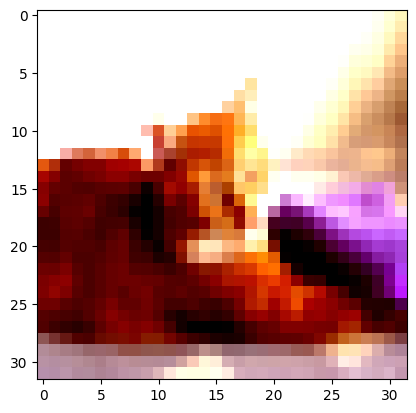

cat


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import numpy as np
loader=DataLoader(trainset, batch_size=1, shuffle=True)
batch=next(iter(loader))
images,labels=batch
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
print(classes[labels])

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(#skip connection
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)


        out += self.shortcut(residual)  # Skip connection
        out = self.relu(out)

        return out


In [9]:
import torch.nn.functional as F


class ResNet(nn.Module):
    def __init__(self, num_blocks, drop_rate, block=ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.mp=nn.MaxPool2d(3,3)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64,120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(drop_rate)
        self.fc3 = nn.Linear(84, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [10]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)
    return val_loss, accuracy

In [11]:
def objective(trial):#tuning with bayesian
    num_blocks = [trial.suggest_int(f'num_blocks_{i}', 1, 3) for i in range(3)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Model, criterion, optimizer
    model = ResNet(num_blocks, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        train(model, device, trainloader, optimizer, criterion)
        val_loss, accuracy = evaluate(model, device, testloader, criterion)

    return val_loss  # Optuna minimizes the objective value

In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-05-27 10:32:36,027] A new study created in memory with name: no-name-8adc85a3-2de4-4388-95cd-50abccb4f6c0
<ipython-input-11-810cfd7ae23d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-05-27 10:39:44,779] Trial 0 finished with value: 0.022121757504343986 and parameters: {'num_blocks_0': 3, 'num_blocks_1': 3, 'num_blocks_2': 1, 'dropout_rate': 0.1436828917777957, 'learning_rate': 0.009714221749181991}. Best is trial 0 with value: 0.022121757504343986.
[I 2024-05-27 10:46:21,180] Trial 1 finished with value: 0.019646032777428626 and parameters: {'num_blocks_0': 1, 'num_blocks_1': 2, 'num_blocks_2': 2, 'dropout_rate': 0.16405598832391954, 'learning_rate': 0.0007355428840279744}. Best is trial 1 with value: 0.019646032777428626.
[I 2024-05-27 10

KeyboardInterrupt: 

In [14]:
best_params=study.best_trial.params
# best_params
model = ResNet([best_params['num_blocks_0'], best_params['num_blocks_1'], best_params['num_blocks_2']], best_params['dropout_rate']).to(device)
PATH = './cifar_net.pth'
# Define the criterion and optimizer
best_val_loss=np.Inf
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Train the model
for epoch in range(30):
    train(model, device, trainloader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, device, testloader, criterion)
    if val_loss<best_val_loss:
      best_val_loss=val_loss
      torch.save(model.state_dict(), PATH)
      print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


Validation Loss: 0.0412, Validation Accuracy: 0.5091
Validation Loss: 0.0329, Validation Accuracy: 0.6227
Validation Loss: 0.0300, Validation Accuracy: 0.6550
Validation Loss: 0.0265, Validation Accuracy: 0.6987
Validation Loss: 0.0234, Validation Accuracy: 0.7413
Validation Loss: 0.0229, Validation Accuracy: 0.7425
Validation Loss: 0.0215, Validation Accuracy: 0.7654
Validation Loss: 0.0191, Validation Accuracy: 0.7934
Validation Loss: 0.0184, Validation Accuracy: 0.7959
Validation Loss: 0.0182, Validation Accuracy: 0.8017
Validation Loss: 0.0180, Validation Accuracy: 0.8074
Validation Loss: 0.0177, Validation Accuracy: 0.8064
Validation Loss: 0.0166, Validation Accuracy: 0.8201
Validation Loss: 0.0160, Validation Accuracy: 0.8243
Validation Loss: 0.0160, Validation Accuracy: 0.8269
Validation Loss: 0.0158, Validation Accuracy: 0.8276
Validation Loss: 0.0155, Validation Accuracy: 0.8317
Validation Loss: 0.0155, Validation Accuracy: 0.8328


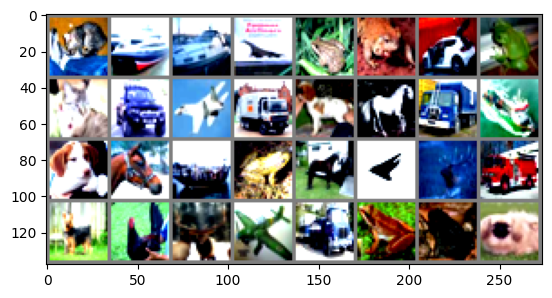

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [15]:
import random
for i in range(random.randint(1,5)):
    dataiter = iter(testloader)
    images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = ResNet([best_params['num_blocks_0'], best_params['num_blocks_1'], best_params['num_blocks_2']], best_params['dropout_rate'])
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

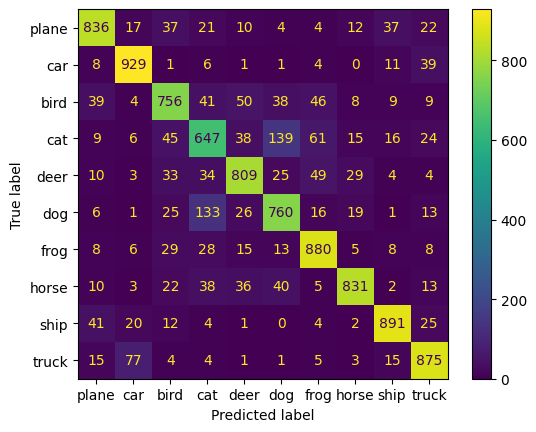

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        predicted_labels.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
cm=confusion_matrix(true_labels, predicted_labels, labels=range(0,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()